In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2],
    c2 = [0.5, 2],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = l1_regularizer,
    mask = True))

see one see two 2 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 1
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 100, Accuracy: 0.9691358024691358, Loss: 0.2216862572564019
Checkpoint 200, Accuracy: 0.9753086419753086, Loss: 0.21643115856029368
Checkpoint 300, Accuracy: 0.9629629629629629, Loss: 0.20233495147139938
Checkpoint 400, Accuracy: 0.9691358024691358, Loss: 0.17801781053896304
Checkpoint 500, Accuracy: 0.9629629629629629, Loss: 0.17216631218239112


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.8874403  0.0861035  0.02645618]
[0. 0. 1.] <-> [0.06250902 0.00270372 0.9347873 ]
[1. 0. 0.] <-> [0.9501529  0.01772022 0.032127  ]
[0. 1. 0.] <-> [0.25086543 0.7287613  0.02037327]
[1. 0. 0.] <-> [0.9363799  0.02466996 0.03895019]
[1. 0. 0.] <-> [0.930317   0.02298312 0.04669993]
[0. 0. 1.] <-> [0.05980242 0.00266148 0.9375361 ]
[1. 0. 0.] <-> [0.931255   0.01557325 0.05317174]
[0. 0. 1.] <-> [0.07568225 0.00348529 0.92083246]
[1. 0. 0.] <-> [0.93135095 0.02028561 0.04836349]
[1. 0. 0.] <-> [0.9266088  0.01614629 0.05724489]
[1. 0. 0.] <-> [0.90272355 0.01861838 0.07865818]
[1. 0. 0.] <-> [0.9159893  0.04681049 0.03720024]
[0. 1. 0.] <-> [0.09764885 0.8954302  0.00692095]
[1. 0. 0.] <-> [0.76976556 0.02180669 0.20842768]
[1. 0. 0.] <-> [0.9250173  0.02330106 0.05168164]
[1. 0. 0.] <-> [0.9143354  0.01615861 0.06950592]
[1. 0. 0.] <-> [0.9205172  0.02018879 0.05929396]
[1. 0. 0.] <-> [0.9291777  0.01866532 0.05215699]
[1. 0. 0.] <-> [0.9312288  0.01714715 0.0516241 ]


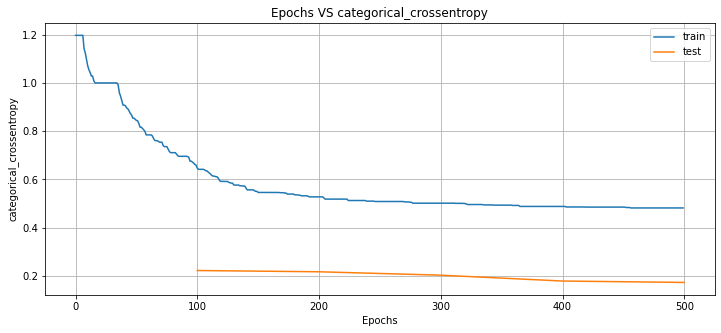

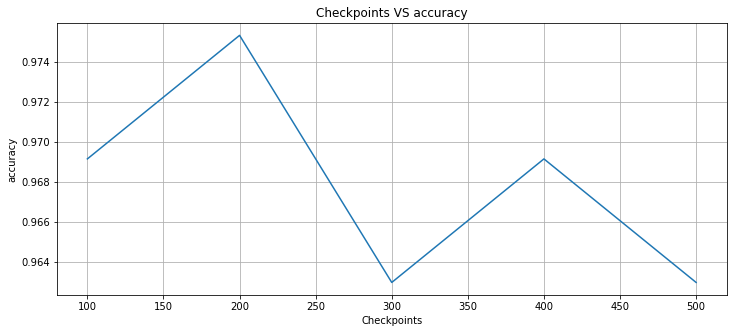

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9691358024691358, 'mean_square_error': 0.0988515263413061, 'categorical_crossentropy': 0.2216862572564019, 'essential_metrics': {0: {'tp_hit': 80, 'fp_hit': 5, 'tn_hit': 23, 'fn_hit': 0}, 1: {'tp_hit': 15, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 0}, 2: {'tp_hit': 8, 'fp_hit': 0, 'tn_hit': 95, 'fn_hit': 5}}, 'checkpoint': 100} 


{'accuracy': 0.9753086419753086, 'mean_square_error': 0.0919840795448944, 'categorical_crossentropy': 0.21643115856029368, 'essential_metrics': {0: {'tp_hit': 79, 'fp_hit': 3, 'tn_hit': 25, 'fn_hit': 1}, 1: {'tp_hit': 14, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 1}, 2: {'tp_hit': 11, 'fp_hit': 1, 'tn_hit': 94, 'fn_hit': 2}}, 'checkpoint': 200} 


{'accuracy': 0.9629629629629629, 'mean_square_error': 0.09279513735545165, 'categorical_crossentropy': 0.20233495147139938, 'essential_metrics': {0: {'tp_hit': 79, 'fp_hit': 5, 'tn_hit': 23, 'fn_hit': 1}, 1: {'tp_hit': 12, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 3}, 2: {'tp_hit': 11, 'fp_hit': 1, 'tn_hit': 94, 'fn

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[ 0.08139332  0.1042466  -0.07997893 -0.14443135  0.06297276]
 bias: 0.15728718042373657

Neuron 1: weights:
[ 1.1864603  -2.5561144  -1.1678706  -0.0142116   0.15973225]
 bias: 1.5338608026504517

Neuron 2: weights:
[ 0.16706054 -1.3619472  -0.36344978  0.7799559   1.734103  ]
 bias: -1.5383931398391724

Neuron 3: weights:
[-0.10745366  0.8807127   0.13461643 -0.18373565 -0.82432044]
 bias: 0.12018787115812302

$
Layer 2
Neuron 0: weights:
[ 0.05438088  3.         -2.5263326   0.08461539]
 bias: -0.25595518946647644

Neuron 1: weights:
[-0.00712167 -3.         -0.20248148  1.8916324 ]
 bias: 0.2809886336326599

Neuron 2: weights:
[ 0.0808133 -0.0329913  3.        -3.       ]
 bias: -0.007396466098725796

$

